In [22]:
import pandas as pd
import numpy as np

You are running a bioreactor in batch mode with a working volume of 50 L. You are growing induced pluripotent stem cells (iPSCs) for islet differentiation. As the operator, it is your duty to generate enough cells to innoculate a 500 L bioreactor. Before starting the run, you want to make sure you have enough reagents. You use previous data for your cell line to simulate your bioreactor run using Monod kinetics. Luckily, the R&D team has done extensive research on the glucose consumption, L-glutamine consumption, lacate producton, and ammonia production of your iPSCs to give you everything you need for your simulation.

Kinetics: 

Cell growth

In [23]:
def Mu(mu_max, c_Glc, c_Gln, K_sGlc, K_sGln):
    return mu_max * (c_Glc / (c_Glc + K_sGlc)) * (c_Gln / (c_Gln + K_sGln))

Cell death

In [24]:
def Mu_d(mu_d_min, mu_d_max, K_sGlc, c_Glc):
    return mu_d_min + mu_d_max * K_sGlc/(K_sGlc + c_Glc)

Glucose consumption

In [25]:
def q_Glc(mu_max, c_Glc, c_Gln, K_sGlc, K_sGln, k_Glc):
    mu = Mu(mu_max, c_Glc, c_Gln, K_sGlc, K_sGln)
    return q_Glc_max * c_Glc * ((mu / (mu + mu_max)) + 0.5) / (c_Glc + k_Glc)

L-glutamine consumption

In [26]:
def q_Gln(c_Gln, c_Glc, q_Gln_max, k_Gln, a, c_Glc_thr):
    if c_Glc > c_Glc_thr:
        Kp_Gln = 1
    else:
        Kp_Gln = 1 + a * (c_Glc_thr - c_Glc)
    return Kp_Gln * q_Gln_max * c_Gln / (c_Gln + k_Gln)

Lactate production

In [27]:
def q_Lac(Y_lacglc, Q_Glc, mu, mu_max, q_Lac_uptake_max):
    Q_Lac = Y_lacglc * Q_Glc - q_Lac_uptake_max * (mu_max - mu) / mu_max
    return Y_lacglc * Q_Glc - q_Lac_uptake_max * (mu_max - mu) / mu_max

Ammonia production

In [28]:
def q_Amm(Y_ammgln, Q_Gln):
    return Y_ammgln * Q_Gln

Kinetic constants:

In [29]:
mu_d_min = 0.0017 #h-1
mu_d_max = 0.0360 #h-1
mu_max = 0.0460 # h-1
k_Glc = 1.8501 #mmol/L
k_Gln = 3.7363 #mmol/L
K_sGlc = 0.03 #mmol/L
K_sGln = 0.03 #mmol/L
q_Glc_max = 0.0726E-9 # mmol/cell/h
q_Gln_max = 0.0770E-9 # mmol/cell/h
Y_ammgln = 0.6562
Y_lacglc = 0.4707
q_Lac_max = 0.0442E-9 #mmol/cell/h
K_lys = 0.0010

You know the initial concentrations by taking a measurment at t=0 and have recorded the findings.

In [30]:
c_Glc_0 = 44.4 #mmol/L
c_Gln_0 = 4 #mmol/L
Xv_0 = 2E7 #cells/L
c_Lac_0 = 0 #mmol/L
c_Amm_0 = 0 #mmol/L

You must now run your simulation. You have a set of ordinary differential equations (ODEs) that you need to solve in series; therefore, you must use an ODE solver.

In [31]:
from scipy.integrate import odeint
from scipy import interpolate

In [32]:
def odes(x, t):
    
    # kinetic constants
    mu_d_min = 0.0017 #h-1
    mu_d_max = 0.0360 #h-1
    mu_max = 0.0460 # h-1
    k_Glc = 1.8501 #mmol/L
    k_Gln = 3.7363 #mmol/L
    K_sGlc = 0.03 #mmol/L
    K_sGln = 0.03 #mmol/L
    q_Glc_max = 0.0726E-9 # mmol/cell/h
    q_Gln_max = 0.0770E-9 # mmol/cell/h
    Y_ammgln = 0.6562
    Y_lacglc = 0.4707
    q_Lac_uptake_max = 0.0442E-9 #mmol/cell/h
    K_lys = 0.001 #h-1
    a = 6
    c_Glc_thr = 0.5
    q_mab = 0.5E-15 #kg/cell/hr
    
    # assign each ode to a vector element
    Xv = x[0]
    c_Glc = x[1]
    c_Gln = x[2]
    c_Lac = x[3]
    c_Amm = x[4]
    
    # non ode equations
    mu = Mu(mu_max, c_Glc, c_Gln, K_sGlc, K_sGln)
    mu_d = Mu_d(mu_d_min, mu_d_max, K_sGlc, c_Glc)
    qglc = q_Glc(mu_max, c_Glc, c_Gln, K_sGlc, K_sGln, k_Glc)
    qgln = q_Gln(c_Gln, c_Glc, q_Gln_max, k_Gln, a, c_Glc_thr)
    qlac = q_Lac(Y_lacglc, qglc, mu, mu_max, q_Lac_uptake_max)
    qamm = q_Amm(Y_ammgln, qgln)
    
    # mass balances
    dXv_dt = (mu - mu_d) * Xv
    dc_Glc_dt = - qglc * Xv
    dc_Gln_dt = - qgln * Xv
    dc_Lac_dt = + qlac * Xv
    dc_Amm_dt = + qamm * Xv
    
    return dXv_dt, dc_Glc_dt, dc_Gln_dt, dc_Lac_dt, dc_Amm_dt

Define time and array of initial conditions to integrate over

In [33]:
t = np.linspace(0, 200, 1000)

In [34]:
x0 = [Xv_0, c_Glc_0, c_Gln_0, c_Lac_0, c_Amm_0]

Run simulation

In [35]:
x = odeint(odes, x0, t)

To make it easier, each vector has been assigned a name

In [36]:
Xv = x[:,0]
glc = x[:,1]
gln = x[:,2]
lac = x[:,3]
amm = x[:,4]

Now we will plot our results

In [37]:
import matplotlib.pyplot as plt

The following is a basic plot of viable cell density (cells/L) versus time

Text(0, 0.5, 'Viable cell density (cells/L)')

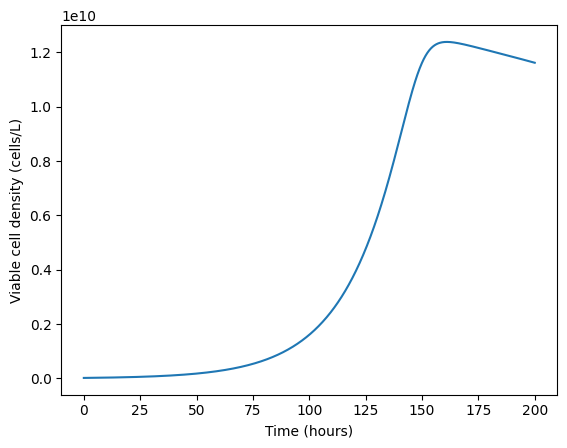

In [38]:
plt.plot(t,Xv)
plt.xlabel('Time (hours)')
plt.ylabel('Viable cell density (cells/L)')

How does the graph change with a log plot? Please show in the box below.

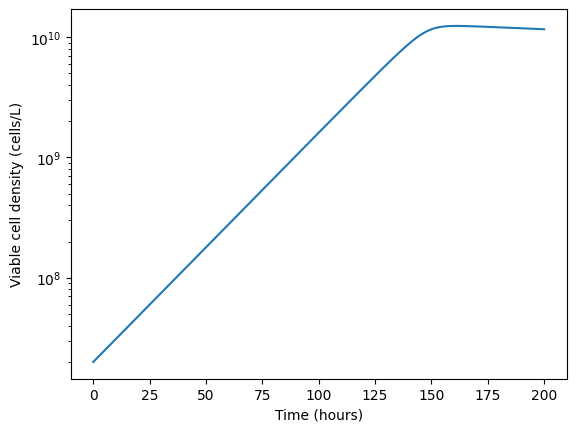

In [39]:
plt.semilogy(t, Xv)
plt.xlabel('Time (hours)')
plt.ylabel('Viable cell density (cells/L)')
plt.show()

What is the growth rate and doubling time of your cells from this simulated data?

In [40]:
import numpy as np

# Define the initial viable cell density (cells/L)
Xv_0 = 2E7  # Initial viable cell density

# Calculate the growth rate
growth_rate = np.log(Xv / Xv_0) / t

# Calculate the doubling time
doubling_time = np.log(2) / growth_rate


C:\Users\irelo\AppData\Local\Temp\ipykernel_17532\1308551428.py:7: RuntimeWarning: invalid value encountered in divide
  growth_rate = np.log(Xv / Xv_0) / t


In the boxes below, make plots of the glucose (glc), l-glutamine (gln), lactate (lac), and ammonia (amm) concentrations with time. Make your plots as simple or as creative as you like. A guide on how to design graphs in python can be found here:

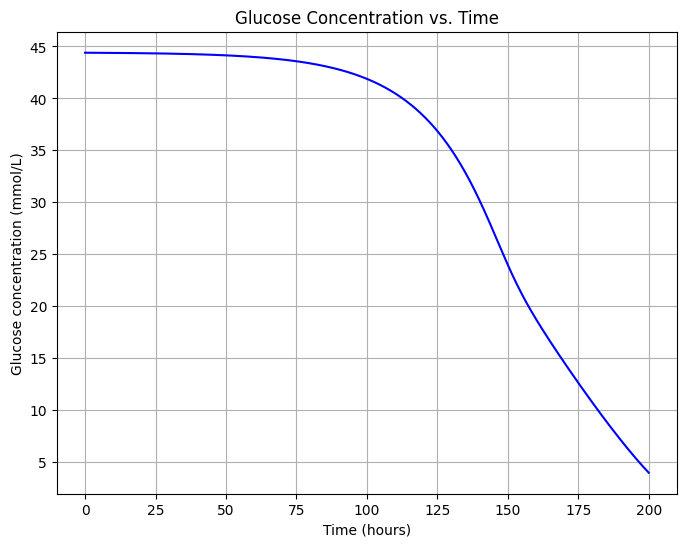

In [41]:
import matplotlib.pyplot as plt

# Plotting the glucose concentration over time
plt.figure(figsize=(8, 6))
plt.plot(t, glc, color='blue')
plt.xlabel('Time (hours)')
plt.ylabel('Glucose concentration (mmol/L)')
plt.title('Glucose Concentration vs. Time')
plt.grid(True)
plt.show()


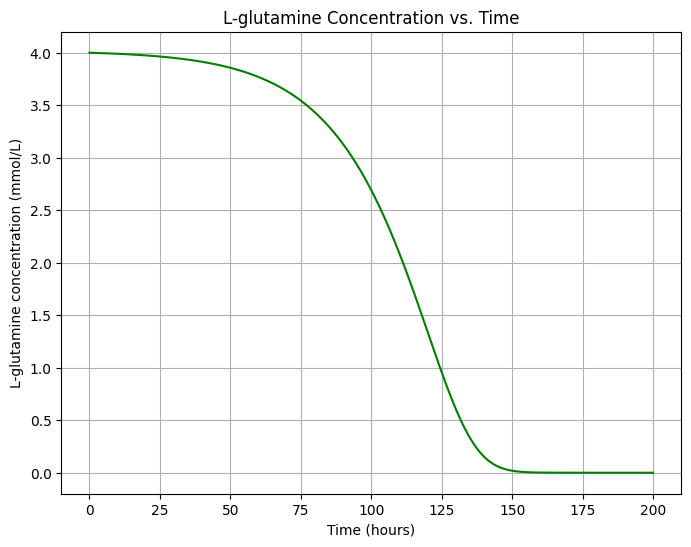

In [42]:
# Plotting the l-glutamine concentration over time
plt.figure(figsize=(8, 6))
plt.plot(t, gln, color='green')
plt.xlabel('Time (hours)')
plt.ylabel('L-glutamine concentration (mmol/L)')
plt.title('L-glutamine Concentration vs. Time')
plt.grid(True)
plt.show()

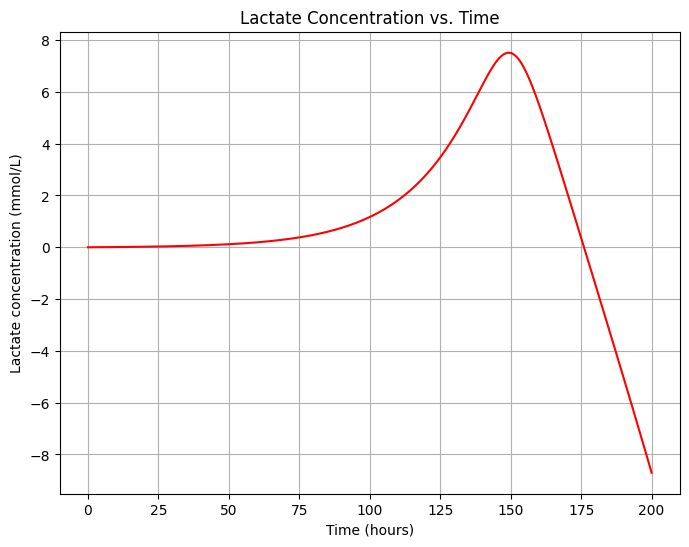

In [43]:
# Plotting the lactate concentration over time
plt.figure(figsize=(8, 6))
plt.plot(t, lac, color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Lactate concentration (mmol/L)')
plt.title('Lactate Concentration vs. Time')
plt.grid(True)
plt.show()

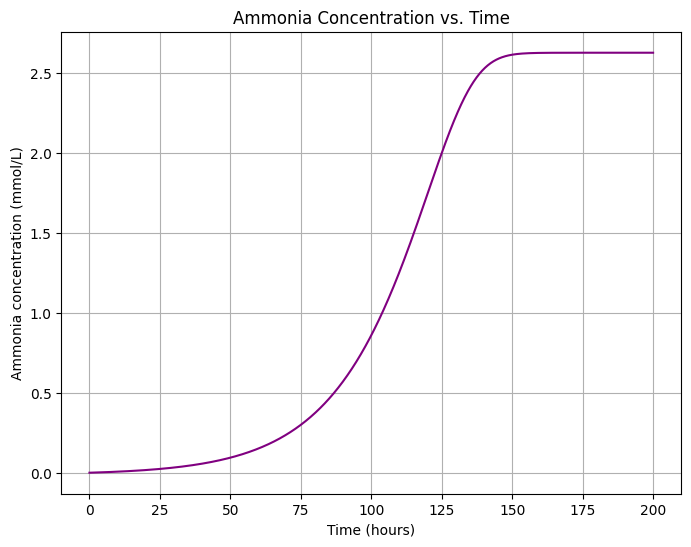

In [44]:
# Plotting the ammonia concentration over time
plt.figure(figsize=(8, 6))
plt.plot(t, amm, color='purple')
plt.xlabel('Time (hours)')
plt.ylabel('Ammonia concentration (mmol/L)')
plt.title('Ammonia Concentration vs. Time')
plt.grid(True)
plt.show()

Now its time to utilize your data. If you wish to innocuate your 500 L bioreactor with the same initial cell density (20,000 cells/ml), after how many days do you have enough cells?

After running your simulation, you verify that you have enough reagents to complete the run and have an estimated timeline for how long the reactor needs to run. You innoculate the reactor at 9 am at your initial cell density of 20,000 cells/mL. You take a daily cell count at 9 am for the next 6 days. You obtain the following data after running the reactor:

In [45]:
d = {'time (days)': [0,1,2,3,4,5,6,7,8], 
     'cell density (cells/L)': [2E7, 2.34E7, 10.634E7, 21.547E7, 46.9987E7, 267.97E7, 587.876E7, 1268.36E7, 1152E7]}
lab_data = pd.DataFrame(data=d)
lab_data

,time (days),cell density (cells/L)
0,0,2.000000e+07
1,1,2.340000e+07
2,2,1.063400e+08
3,3,2.154700e+08
4,4,4.699870e+08
5,5,2.679700e+09
6,6,5.878760e+09
7,7,1.268360e+10
8,8,1.152000e+10


Please plot the viable cell density from your data ('lab_data') with time.

What is the doubling time and growth rate of your cells from your lab data?

Overlay the simulated viable cell density and the measured cell density. Calculate the difference between these two curves and give a statistical measure of the difference.

Your supervisor asks you if we can innoculate a 1000 L reactor instead of a 500 L reactor. You realize that with your current bioreactor kinetics, you do not produce enough cells to innoculate this large of a reactor. You then decide to use a fed-batch reactor with a flowrate of 15L/day to try and achieve a higher viable cell density. How would you change the mass balances in the function 'odes' to run a fed-batch reactor simulation? Please do so, and rerun the simulation. 

Helpful tip:

You need to account for the volume change of the bioreactor with time. Take a look at the mass balances in the power point for more help.

Do not change any of the above code. Just rerun the simulation below.

Plot the viable cell density, glucose, l-glutamine, lactate, and ammonia concentrations of the fed-batch compared to the batch reactor below. 

How many cells do you need to innoculate a 1000 L reactor? After how many days can you inoculate the 1000 L reactor?

Export this notebook as a pdf, or take screen shots and put into a word document to hand in your work in the drop box.